## <font color = 'black'> Importing Necessary Libraries

# Pairs Trading
Pairs Trading is a market-neutral trading strategy which involves matching a long position with a short position in two securities which have a high level of positive cointegration. It is a form of statistical arbitrage i.e it looks at the relative price movement between the two securities.

As it is a market-neutral strategy, it is independent of the trend being followed by the overall market (upwards or downwards or sideways). Instead, pairs trading works on the concept of mean-reversion. When two highly cointegrated securites deviate from their general trend, it is expected that they will return back to that trend in the future.

The spread between the stock prices created during the deviation serves as an opportunity for profit. One can open a long position on the stock expected to move upwards and a short position on the stock expected to move downwards. If the pair performs as expected, it is a profitable trade.

Even if the pair does not perform as expected, the trader will be able to mitigate some portion of their losses as the loss on one security will be offset by the profits on the other security. Hence, pairs trading also acts as a form of hedging and can be used to minimise losses.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install yfinance
# !pip install niftystocks
# !pip install quantstats

import yfinance as yf
from niftystocks import ns
import statsmodels.api as sm
import quantstats as qs
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings('ignore')

## <font color='black'>Fetching the Stock Price Data

In [36]:
# Collecting all tickers in nifty 100
tickers = ns.get_nifty100_with_ns()

In [37]:
# Fetching stock data for all tickers
stock_data = {}

start_date = "2017-06-01"
end_date = "2020-06-30"

for stock in tickers:
  ticker = yf.Ticker(stock)
  stock_data[stock] = ticker.history(start = start_date, end = end_date)['Close']

stock_prices = pd.DataFrame(stock_data)

MOTHERSUMI.NS: No timezone found, symbol may be delisted
HDFC.NS: No price data found, symbol may be delisted (1d 2017-06-01 -> 2020-06-30)
LTI.NS: No timezone found, symbol may be delisted
CADILAHC.NS: No timezone found, symbol may be delisted


In [38]:
stock_prices.dropna(axis=1, inplace=True)
stock_prices.sort_index(inplace=True)
stock_prices

,HDFCBANK.NS,IGL.NS,IOC.NS,SHREECEM.NS,TATACONSUM.NS,TATAMOTORS.NS,ADANIPORTS.NS,AMBUJACEM.NS,DABUR.NS,GODREJCP.NS,...,VEDL.NS,BIOCON.NS,INDUSTOWER.NS,ITC.NS,JSWSTEEL.NS,LUPIN.NS,M&M.NS,MUTHOOTFIN.NS,PETRONET.NS,SUNPHARMA.NS
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01 00:00:00+05:30,775.601501,197.573456,89.768700,17246.242188,140.395767,475.169037,335.366516,206.618134,264.343414,586.118042,...,97.895432,156.432037,277.333466,251.722748,164.863846,1099.419434,659.216125,362.687927,169.996643,478.488953
2017-06-02 00:00:00+05:30,778.292297,202.113983,89.974762,17544.080078,142.652786,477.262512,343.721893,206.704086,263.648590,587.296570,...,96.879425,158.786240,276.154053,255.728546,164.273392,1119.368896,656.094177,378.833954,171.128693,485.466583
2017-06-05 00:00:00+05:30,778.911377,201.538315,91.547379,18191.103516,142.744888,476.664368,346.747040,206.618134,264.760223,586.214783,...,97.112274,160.862534,281.903503,258.168274,160.688507,1108.914429,658.499146,383.611359,167.559906,483.533569
2017-06-06 00:00:00+05:30,780.530518,207.388062,92.100487,17727.851562,140.948486,459.567657,347.131256,202.061951,261.934784,586.892822,...,97.112274,162.105011,282.419434,252.963409,162.038116,1103.927246,652.833252,375.870148,172.721207,475.518707
2017-06-07 00:00:00+05:30,781.411621,205.428879,92.696999,17658.052734,143.297653,456.576996,344.874329,203.394440,262.907501,601.181885,...,98.720917,163.118622,282.456268,253.939331,164.821701,1107.236084,662.291992,388.565796,168.845398,482.354950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23 00:00:00+05:30,1014.249207,428.819519,46.185093,22526.179688,381.296661,104.075630,348.403717,174.391800,445.133240,664.950012,...,56.572983,391.281372,201.805450,156.980606,181.197815,916.970642,492.948517,1068.746216,218.791199,483.050476
2020-06-24 00:00:00+05:30,1004.712830,419.364777,45.022068,22338.099609,373.736115,104.474388,344.681122,170.285812,441.687469,671.700012,...,56.290115,384.768219,202.413422,162.048599,174.233841,900.838928,491.946136,1054.016846,221.319122,467.558533
2020-06-25 00:00:00+05:30,1001.063782,420.877533,43.962421,21845.679688,374.614075,103.477493,336.991058,168.074905,445.667114,676.299988,...,57.215866,398.978699,198.418137,170.706406,173.919357,914.379822,484.213959,1046.486694,219.760239,470.695465


## <font color='black'> Finding Correlated Pairs (Pretest) 

In [39]:
def find_correlated_pairs(df, threshold):
    corr_matrix = df.corr()
    n = corr_matrix.shape[0]
    result = pd.DataFrame(columns=['Asset 1', 'Asset 2', 'Correlation Coefficient'])
    for i in range(n):
        for j in range(i+1, n):
            correlation = corr_matrix.iloc[i, j]
            if(correlation >= threshold):
                result = result.append({'Asset 1': df.columns[i], 'Asset 2': df.columns[j],
                                        'Correlation Coefficient': correlation}, ignore_index=True)
    return result

In [40]:
corr_pairs = find_correlated_pairs(stock_prices, 0.9)
corr_pairs

,Asset 1,Asset 2,Correlation Coefficient
0,HDFCBANK.NS,BAJAJFINSV.NS,0.951987
1,HDFCBANK.NS,KOTAKBANK.NS,0.939886
2,HDFCBANK.NS,BAJFINANCE.NS,0.930653
3,TATAMOTORS.NS,PNB.NS,0.916492
4,DABUR.NS,HINDUNILVR.NS,0.941126
5,DABUR.NS,PIDILITIND.NS,0.906884
6,PGHH.NS,TITAN.NS,0.925741
7,HEROMOTOCO.NS,EICHERMOT.NS,0.915297
8,HEROMOTOCO.NS,VEDL.NS,0.910467
9,HINDUNILVR.NS,ASIANPAINT.NS,0.922179


After performing correlation test with a threshold of 0.9, we have obtained 50 pairs of stocks out of 89*88/2 = 3916 possible pairs for further consideration.

## <font color='black'> Finding Cointegrated Pairs

In [41]:
def finding_cointegrated_pairs(df, threshold):
    n = corr_pairs.shape[0]
    result = pd.DataFrame(columns=['Asset 1', 'Asset 2', 'Correlation' , 'p-value'])
    for i in range(n):
      p_value = coint(stock_prices[corr_pairs['Asset 1'][i]], stock_prices[corr_pairs['Asset 2'][i]])
      if(p_value[1] <= threshold):
        result = result.append({'Asset 1': corr_pairs['Asset 1'][i], 'Asset 2': corr_pairs['Asset 2'][i],
                                'Correlation': corr_pairs['Correlation Coefficient'][i], 'p-value': p_value[1]},
                                ignore_index=True)
    return result

In [42]:
coint_pairs = finding_cointegrated_pairs(corr_pairs, 0.01)
coint_pairs

,Asset 1,Asset 2,Correlation,p-value
0,PGHH.NS,TITAN.NS,0.925741,0.001186
1,HEROMOTOCO.NS,VEDL.NS,0.910467,0.005902
2,HINDUNILVR.NS,PIDILITIND.NS,0.948760,0.004872
3,GRASIM.NS,VEDL.NS,0.955442,0.008603
4,INFY.NS,TCS.NS,0.961302,0.000063
5,ONGC.NS,COALINDIA.NS,0.925352,0.005338
6,ONGC.NS,NTPC.NS,0.913341,0.001108
7,KOTAKBANK.NS,BAJFINANCE.NS,0.952266,0.002839
8,DIVISLAB.NS,TORNTPHARM.NS,0.936711,0.009718


After performing cointegration test with a threshold of 0.01, we have obtained 9 pairs of stocks out of 8 pairs for further consideration.

## <font color='black'>Calculating Hedge Ratios

In [43]:
def calculate_hedge_ratio(df):
    hedge_ratio = []
    n = df.shape[0]
    for i in range(n):
        covariance = np.cov(stock_prices[df.iloc[i, 0]], stock_prices[df.iloc[i, 1]])[0, 1]
        variance = np.var(stock_prices[df.iloc[i, 0]])
        hedge_ratio.append(covariance/variance)
    return hedge_ratio

In [44]:
coint_pairs['Hedge Ratio'] = calculate_hedge_ratio(coint_pairs)

To choose from remaining 9 pairs, we will choose the pair whose hedge ratio is nearest to 1

In [45]:
coint_pairs['criterion'] = np.abs(coint_pairs['Hedge Ratio'] - 1)
coint_pairs.sort_values(by='criterion', inplace=True)
coint_pairs

,Asset 1,Asset 2,Correlation,p-value,Hedge Ratio,criterion
5,ONGC.NS,COALINDIA.NS,0.925352,0.005338,1.022515,0.022515
2,HINDUNILVR.NS,PIDILITIND.NS,0.948760,0.004872,0.685660,0.314340
6,ONGC.NS,NTPC.NS,0.913341,0.001108,0.424748,0.575252
8,DIVISLAB.NS,TORNTPHARM.NS,0.936711,0.009718,0.337628,0.662372
0,PGHH.NS,TITAN.NS,0.925741,0.001186,0.196795,0.803205
3,GRASIM.NS,VEDL.NS,0.955442,0.008603,0.146358,0.853642
1,HEROMOTOCO.NS,VEDL.NS,0.910467,0.005902,0.060714,0.939286
4,INFY.NS,TCS.NS,0.961302,0.000063,3.038109,2.038109
7,KOTAKBANK.NS,BAJFINANCE.NS,0.952266,0.002839,3.808409,2.808409


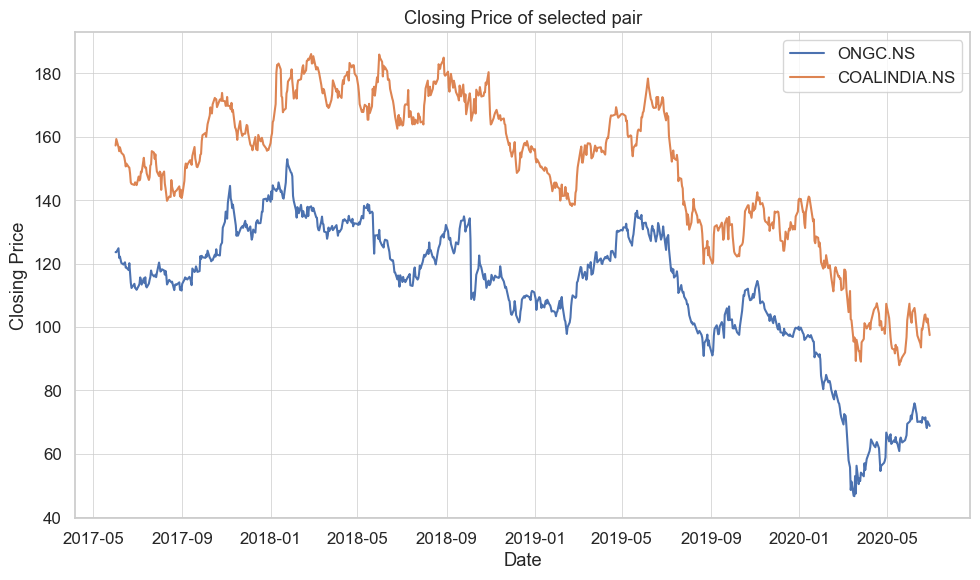

In [46]:
sns.lineplot(stock_prices[coint_pairs.iloc[0, 0]], label=coint_pairs.iloc[0, 0])
sns.lineplot(stock_prices[coint_pairs.iloc[0, 1]], label=coint_pairs.iloc[0, 1])
plt.title('Closing Price of selected pair')
plt.ylabel('Closing Price')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

## <font color='black'>Selected Pair of Stocks

In [47]:
stock1 = coint_pairs.iloc[0, 1]
stock2 = coint_pairs.iloc[0, 0]

hedge_ratio = coint_pairs.iloc[0, 4]

In [48]:
startdate = "2020-07-01"
enddate = "2023-07-31"

stockprices = yf.download([stock1, stock2], start=startdate, end=enddate)['Close']

[*********************100%%**********************]  2 of 2 completed


In [49]:
stockprices

,COALINDIA.NS,ONGC.NS
Date,,
2020-07-01,133.850006,80.449997
2020-07-02,133.600006,81.849998
2020-07-03,135.250000,82.400002
2020-07-06,135.850006,83.750000
2020-07-07,132.850006,81.949997
...,...,...
2023-07-24,230.949997,171.000000
2023-07-25,229.949997,173.000000
2023-07-26,230.500000,172.949997


### <font color='black'> Calculating spread

In [50]:
spread = -stockprices[stock1]*hedge_ratio + stockprices[stock2]

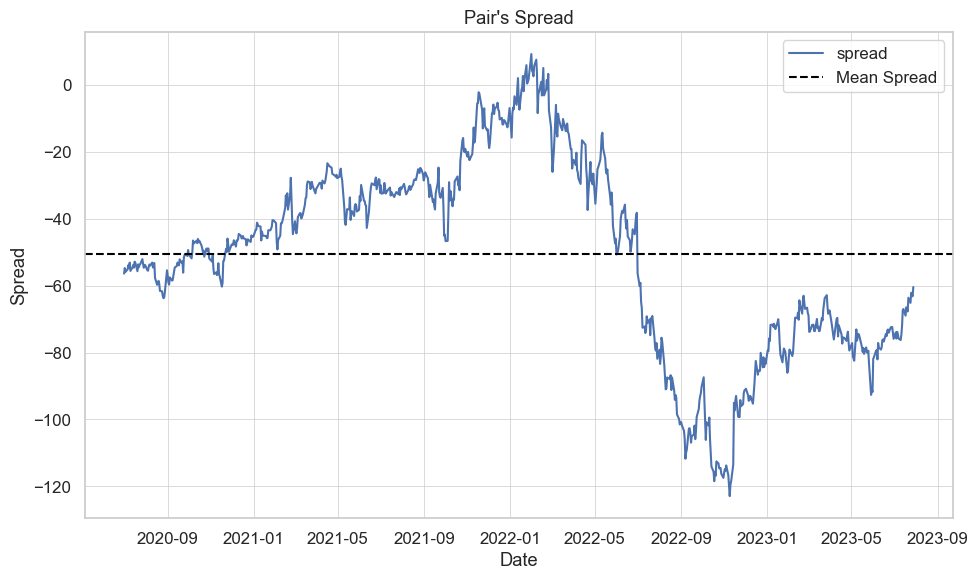

In [51]:
sns.lineplot(spread, label='spread')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean Spread')
plt.title("Pair's Spread")
plt.ylabel('Spread')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.legend()
plt.tight_layout()
plt.show()

### <font color='black'>Calculating z-score

In [52]:
def zscore(series):
    lookback = 21
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])

In [53]:
zscore = zscore(spread)

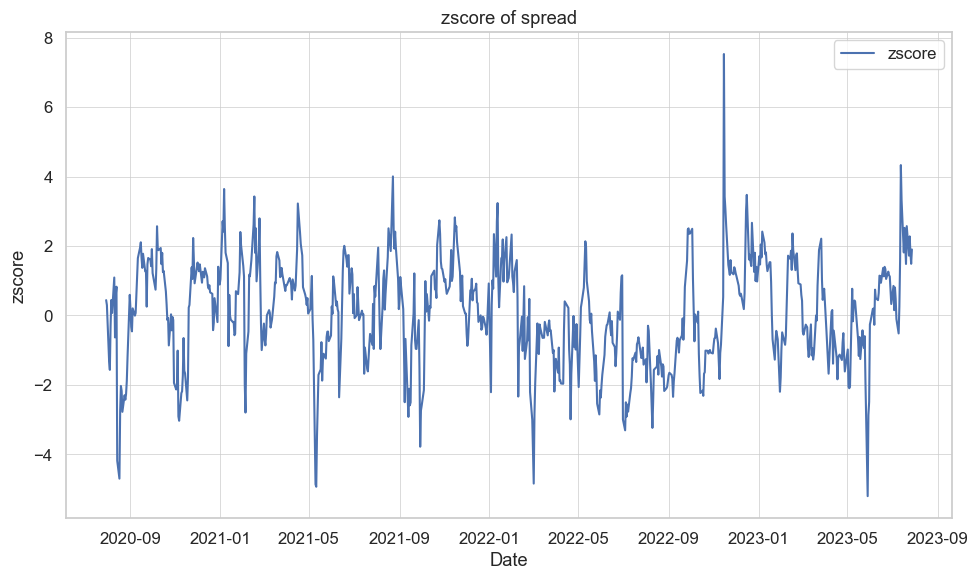

In [54]:
sns.lineplot(zscore, label = 'zscore')
plt.title("zscore of spread")
plt.ylabel('zscore')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

## <font color='black'>Trading Strategy

### <font color='black'>Generation of Signals

In [55]:
# Create a dataframe for trading signals
signals = pd.DataFrame()
signals[stock1] = stockprices[stock1]
signals[stock2] = stockprices[stock2]
signals['spread'] = spread
signals['zscore'] = zscore

signals.dropna(inplace = True)

signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
signals['position1'] = 0

signals['position1'] = signals['signal1'].diff()
if signals['signal1'][0] != 0:
    signals['position1'][0] = signals['signal1'][0]   
signals['signal2'] = -signals['signal1']
signals['position2'] = -signals['position1']

signals.dropna(inplace = True)
signals

,COALINDIA.NS,ONGC.NS,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2020-07-31,129.250000,78.300003,-53.860054,0.298153,0,0.0,0,-0.0
2020-08-03,128.399994,75.900002,-55.390911,-1.314411,-1,-1.0,1,1.0
2020-08-04,128.750000,76.099998,-55.548801,-1.566754,-1,0.0,1,-0.0
2020-08-05,128.449997,76.949997,-54.392045,-0.299394,0,1.0,0,-1.0
2020-08-06,128.850006,78.050003,-53.701054,0.445364,0,0.0,0,-0.0
...,...,...,...,...,...,...,...,...
2023-07-24,230.949997,171.000000,-65.149824,1.722453,1,0.0,-1,-0.0
2023-07-25,229.949997,173.000000,-62.127309,2.276172,1,0.0,-1,-0.0
2023-07-26,230.500000,172.949997,-62.739698,1.799487,1,0.0,-1,-0.0


### <font color='black'>Visualizing Long and Short Positions

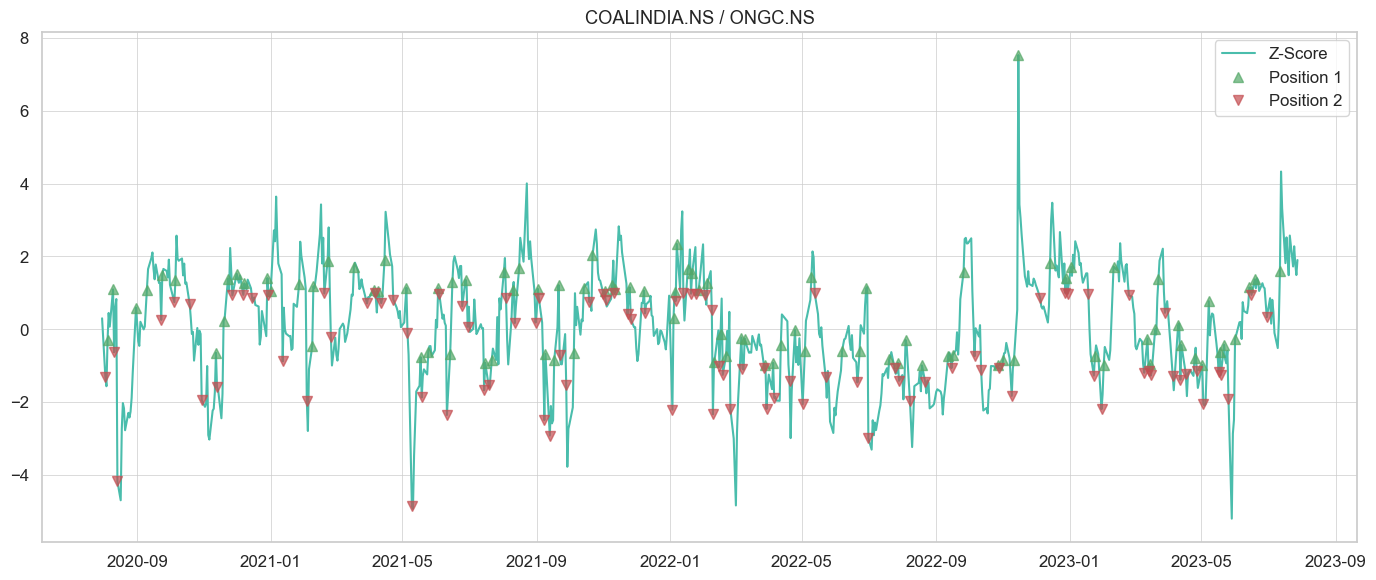

In [56]:
fig = plt.figure(figsize=(14, 6))
bx = fig.add_subplot(111)
series = bx.plot(signals['zscore'], c='#4abdac')
a = (signals['position1'] == 1) | (signals['position1'] == 2)
b = (signals['position1'] == -1) | (signals['position1'] == -2)
long = bx.plot(signals['zscore'][a], lw = 0, marker = '^', markersize = 7, c = 'g', alpha = 0.7)
short = bx.plot(signals['zscore'][b], lw = 0, marker = 'v', markersize = 7, c = 'r', alpha = 0.7)
plt.title(f'{stock1} / {stock2}')
plt.legend(['Z-Score', 'Position 1', 'Position 2'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

Position 1 --  Buy COALINDIA.NS and Sell ONGC.NS <br>
Position 2 -- Sell COALINDIA.NS and Buy ONGC.NS

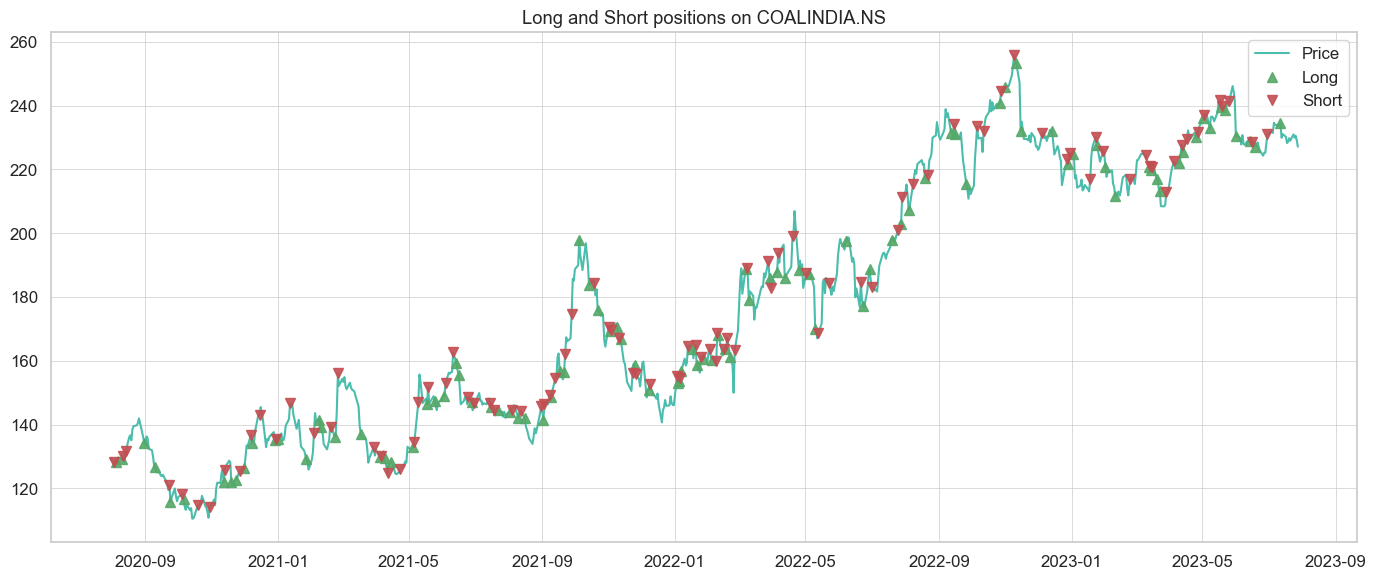

In [57]:
fig = plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)
l1 = bx.plot(signals[stock1], c='#4abdac')
u1 = bx.plot(signals[stock1][a], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
u2, = bx.plot(signals[stock1][b], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
plt.title('Long and Short positions on '+ str(stock1))
plt.legend(['Price', 'Long', 'Short'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

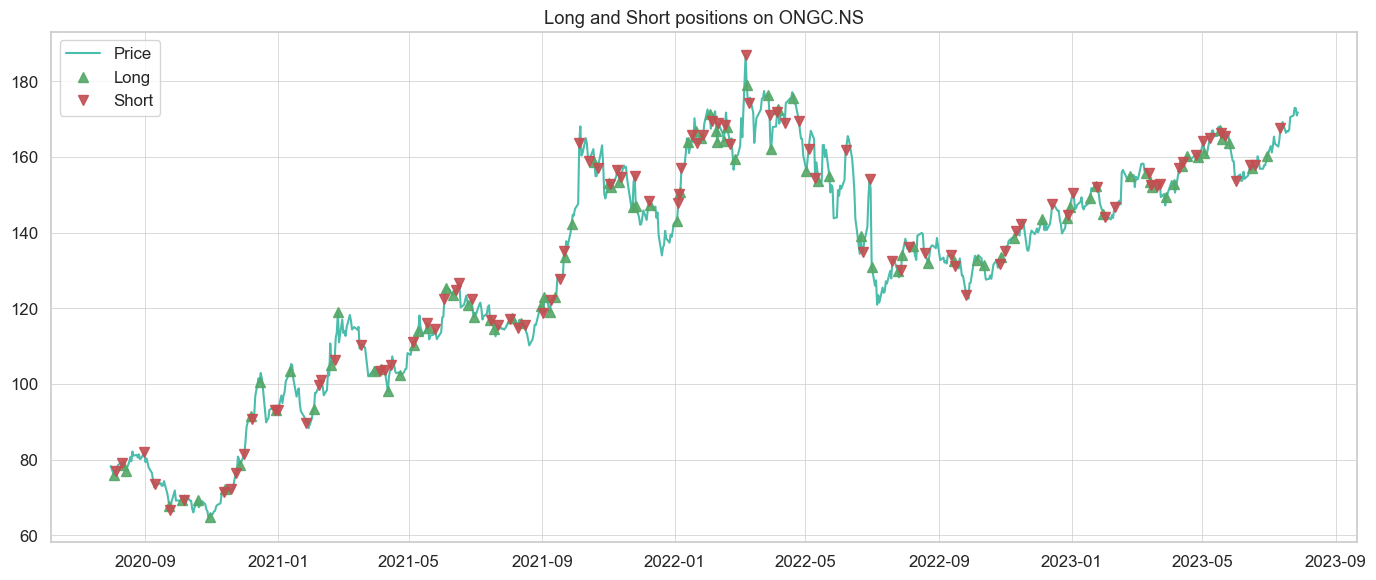

In [58]:
fig = plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)
l1 = bx.plot(signals[stock2], c='#4abdac')
u1 = bx.plot(signals[stock2][b], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
u2, = bx.plot(signals[stock2][a], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
plt.title('Long and Short positions on '+ str(stock2))
plt.legend(['Price', 'Long', 'Short'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

### <font color='black'>Visualising daily closing prices on backtesting period

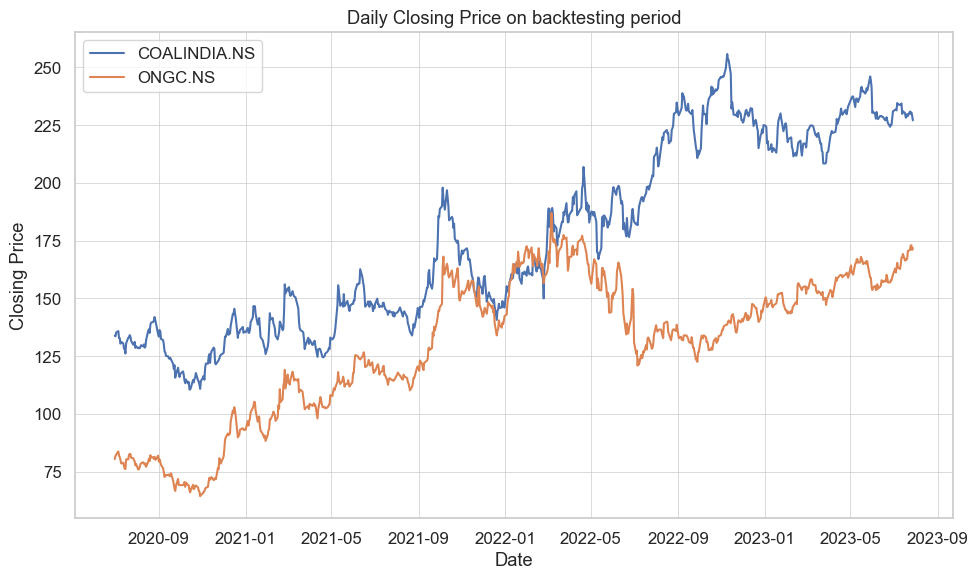

In [59]:
sns.lineplot(stockprices[stock1], label=stock1)
sns.lineplot(stockprices[stock2], label=stock2)
plt.title('Daily Closing Price on backtesting period')
plt.ylabel('Closing Price')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

### <font color='black'>Generating Portfolio

In [60]:
initial_capital = 100000

w1 = 0.5
w2 = 1 - w1

# Shares to buy for each stock
shares1 = (w1*initial_capital)// (signals[stock1][0])
shares2 = (w2*initial_capital)// (signals[stock2][0])

#PnL for stock 1
portfolio = pd.DataFrame()
portfolio['holdings1'] = signals['position1'].cumsum() * signals[stock1] * shares1
portfolio['cash1'] = w1*initial_capital - (signals['position1'] * signals[stock1] * shares1).cumsum()
portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total1'].pct_change()

# PnL for stock 2
portfolio['holdings2'] = signals['position2'].cumsum() * signals[stock2] * shares2
portfolio['cash2'] = w2*initial_capital - (signals['position2'] * signals[stock2] * shares2).cumsum()
portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total2'].pct_change()

# Total PnL
portfolio['total'] = portfolio['total1'] + portfolio['total2']
portfolio = portfolio.dropna()

In [61]:
portfolio

,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2020-08-03,-49562.397644,99562.397644,50000.000000,0.000000,48424.200974,1575.799026,50000.000000,0.000000,100000.000000
2020-08-04,-49697.500000,99562.397644,49864.897644,-0.002702,48551.799026,1575.799026,50127.598053,0.002552,99992.495697
2020-08-05,0.000000,49980.698822,49980.698822,0.002322,0.000000,50669.897079,50669.897079,0.010818,100650.595901
2020-08-06,0.000000,49980.698822,49980.698822,0.000000,0.000000,50669.897079,50669.897079,0.000000,100650.595901
2020-08-07,0.000000,49980.698822,49980.698822,0.000000,0.000000,50669.897079,50669.897079,0.000000,100650.595901
...,...,...,...,...,...,...,...,...,...
2023-07-24,89146.698822,-22992.567017,66154.131805,0.011509,-109098.000000,210393.200974,101295.200974,-0.002826,167449.332779
2023-07-25,88760.698822,-22992.567017,65768.131805,-0.005835,-110374.000000,210393.200974,100019.200974,-0.012597,165787.332779
2023-07-26,88973.000000,-22992.567017,65980.432983,0.003228,-110342.098053,210393.200974,100051.102921,0.000319,166031.535904


### <font color='black'>Visualizing Portfolio PnL

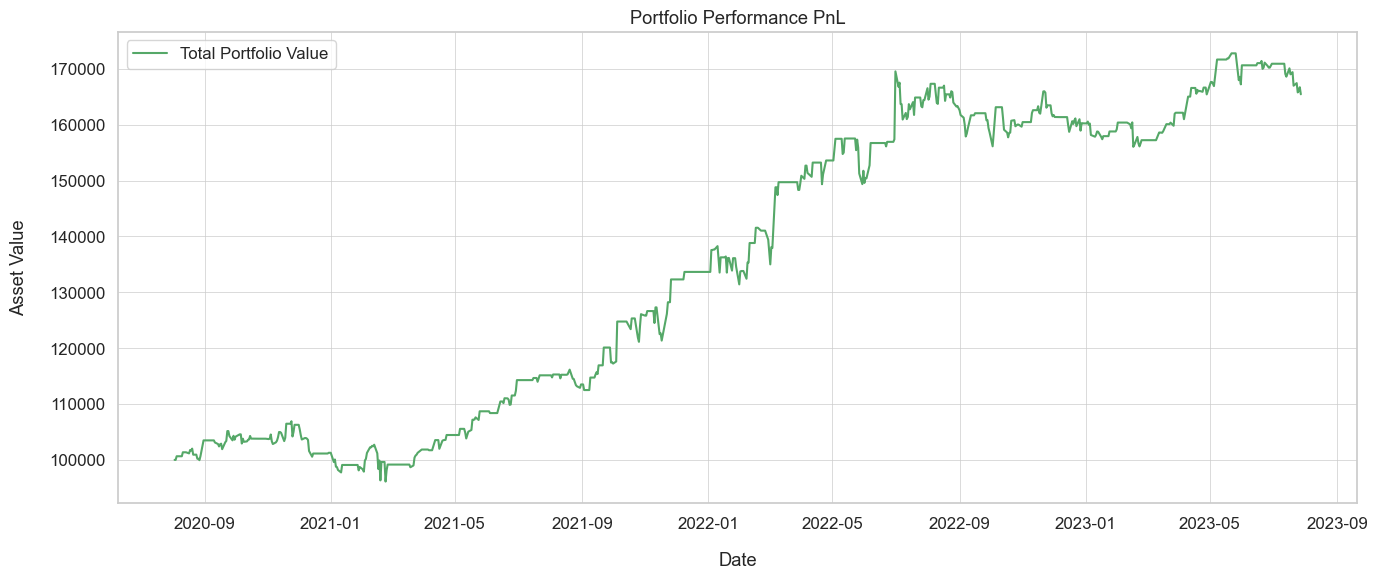

In [62]:
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
l1, = ax.plot(portfolio['total'], c='g')
ax.set_ylabel('Asset Value')
ax.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance PnL')
plt.legend(['Total Portfolio Value'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

### <font color='black'>Performance Metrics of Trading Strategy on Selected Pair of Stocks

In [63]:
final_portfolio = portfolio['total'].iloc[-1]
initial_portfolio = portfolio['total'].iloc[0]
delta = len(portfolio.index)
print('Number of trading days = ', delta)
YEAR_DAYS = 252
returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

Number of trading days =  744
CAGR = 18.595%


In [64]:
cummulative_return = (final_portfolio/initial_portfolio)-1
print('Cummulative Return = {:.3f}%' .format(cummulative_return * 100))

Cummulative Return = 65.453%


In [65]:
drawdown = qs.stats.max_drawdown(portfolio['total'])
print("Maximmum Drawdown of trading strategy:", np.round(drawdown*100, 3), "%")

Maximmum Drawdown of trading strategy: -10.102 %


In [66]:
sharpe_ratio = qs.stats.sharpe(portfolio['total'])
print("Sharpe Ratio:", np.round(sharpe_ratio, 3))

Sharpe Ratio: 1.196


In [67]:
print('Frequency of trades:', np.round(abs(signals['position1']).sum()/len(portfolio)*252, 3), 'per year')

Frequency of trades: 66.048 per year
